# Part 1: Monitoring with MLflow when ML training

The script is exactly same as 02_modify+modeling part.


Just that we:
- Try to find the version of pycaret which is compatible with mlflow python library
- Put the argument `log_experiment=True` in the pycaret setup() function, so it could log the experiment result to MLflow server.

Btw, our MLflow server is hosted at https://mlflow.tanyongsheng.site

In [1]:
# Install the required packages
!pip install -q pycaret[full] imblearn mlflow==2.11.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 45.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from mlflow import set_tracking_uri
set_tracking_uri('https://mlflow.tanyongsheng.site')

In [3]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv("https://drive.google.com/uc?export=download&id=1vRwN2C0oBgWd-Tnvrrcb0mKsy7wUXKfU")
df.columns = ["id", "gender", "age", "hypertension",	"heart_disease",
              "ever_married", "work_type", "residence_type", "avg_glucose_level",
              "bmi", "smoking_status", "stroke"]

# Assign data type to the columns
#df["gender"] = df["gender"].astype(pd.StringDtype())
#df["work_type"] = df["work_type"].astype(pd.StringDtype())
#df["residence_type"] = df["residence_type"].astype(pd.StringDtype())
#df["smoking_status"] = df["smoking_status"].astype(pd.StringDtype())
df["ever_married"] = df["ever_married"].map({"Yes": 1, "No": 0}).astype(int)
df["hypertension"] = df["hypertension"].astype(int)
df["heart_disease"] = df["heart_disease"].astype(int)


# drop id column
df = df.drop(columns=["id"])

In [4]:
# define categorical and numerical columns

numerical_var = ["age", "average_glucose_level", "bmi"]
categorical_var = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "smoking_status"]
target_var = ["stroke"]

In [5]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,1,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,1,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,1,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,1,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,1,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,1,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,1,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,1,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,1,Private,Rural,166.29,25.6,formerly smoked,0


### (i) One-hot encoding

In [6]:
data = df[['gender', 'age', 'hypertension', 'heart_disease',
           'ever_married', 'work_type', 'residence_type',	'avg_glucose_level',
           'bmi',	'smoking_status',	'stroke']].copy(deep=True)

df_encoded = pd.get_dummies(data, columns=['gender', 'smoking_status',
                                'work_type', 'residence_type'],
                              drop_first=True)

In [7]:
df_encoded

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Urban
0,67.0,0,1,1,228.69,36.6,1,True,False,True,False,False,False,True,False,False,True
1,61.0,0,0,1,202.21,NaN,1,False,False,False,True,False,False,False,True,False,False
2,80.0,0,1,1,105.92,32.5,1,True,False,False,True,False,False,True,False,False,False
3,49.0,0,0,1,171.23,34.4,1,False,False,False,False,True,False,True,False,False,True
4,79.0,1,0,1,174.12,24.0,1,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,1,83.75,NaN,0,False,False,False,True,False,False,True,False,False,True
5106,81.0,0,0,1,125.20,40.0,0,False,False,False,True,False,False,False,True,False,True
5107,35.0,0,0,1,82.99,30.6,0,False,False,False,True,False,False,False,True,False,False
5108,51.0,0,0,1,166.29,25.6,0,True,False,True,False,False,False,True,False,False,False


In [8]:
# we will drop `gender_Other` variable as it's has only 1 row
df_encoded = df_encoded.drop(columns=["gender_Other"])


### (ii) Train Test split

In [9]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Split the dataset using stratification
X = df_encoded.drop(columns='stroke', axis=1)  # Features
y = df_encoded['stroke']  # Target

X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.2, stratify=y, random_state=42)

# combine X_train and y_train data
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

### (iii) Missing Value Imputation for `bmi` column

- `bmi`

  - **Type of missing value**: MAR
  - **Explanation**: The missingness depends on observed variables like gender and age group, etc, and not on the value of the `bmi` itself
  - **Other observation**: 3% of the data is missing
  - **Approach**:
      - Implement mean imputation
      - Create missingness indicator variable named `bmi_missing`

In [10]:
# check missing values in `bmi` column

## Check missing values in the training set
print("\nMissing values of `bmi` column in the training set X_train:", X_train["bmi"].isnull().sum())

## Check missing values in the test set
print("\nMissing values of `bmi` column in the test set X_test:", X_test["bmi"].isnull().sum())


Missing values of `bmi` column in the training set X_train: 170

Missing values of `bmi` column in the test set X_test: 31


In [11]:
X_train["bmi"].fillna(X_train["bmi"].mean(), inplace=True)
X_test["bmi"].fillna(X_test["bmi"].mean(), inplace=True)


In [12]:
# check missing values in `bmi` column

## Check missing values in the training set
print("\nMissing values of `bmi` column in the training set X_train:", X_train["bmi"].isnull().sum())

## Check missing values in the test set
print("\nMissing values of `bmi` column in the test set X_test:", X_test["bmi"].isnull().sum())


Missing values of `bmi` column in the training set X_train: 0

Missing values of `bmi` column in the test set X_test: 0


### （iv） SMOTE re-sampling

In [13]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

# Then create and apply the resampling pipeline only to training data
over = SMOTE(sampling_strategy=1)
under = RandomUnderSampler(sampling_strategy=0.1)

steps = [('under', under), ('over', over)]
pipeline = Pipeline(steps=steps)

# Apply the resampling
X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)
# Convert y_train_resampled to Series with the same name as original y
X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
y_train_res = pd.Series(y_train_res, name=y.name)


print("Original training set distribution:", Counter(y_train))
print("Resampled training set distribution:", Counter(y_train_res))
print("Test set distribution (unchanged):", Counter(y_test))

Original training set distribution: Counter({0: 3889, 1: 199})
Resampled training set distribution: Counter({0: 1990, 1: 1990})
Test set distribution (unchanged): Counter({0: 972, 1: 50})


In [14]:
# combine back the smote re-sampling dataset
train_data_res = pd.concat([X_train_res, y_train_res], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Step 4: Modeling

### (i) Building a decision tree model as benchmark

In [48]:
from pycaret.classification import *

dt_experiment = setup(data=train_data_res,
                      target="stroke",
                      test_data=test_data,
                      session_id=24, # seed config to ensure experiment's reproducility
                      preprocess=False, # since we've manually do the feature engineer
                      #max_encoding_ohe = 25,
                      normalize=True,
                      normalize_method = 'zscore', # apply zscore for numeric feature
                      fix_imbalance=False,
                      # fix_imbalance_method='SMOTE',
                      experiment_name = "dt_stroke_classification",
                      log_experiment=True,
                      log_plots=True,
                      log_profile=False,
                      log_data=True,
                      profile=True,
                      index=False)
dt_model = create_model('dt', fold=5, max_depth=5)
dt_model

,Description,Value
0,Session id,24
1,Target,stroke
2,Target type,Binary
3,Original data shape,"(5002, 16)"
4,Transformed data shape,"(5002, 16)"
5,Transformed train set shape,"(3980, 16)"
6,Transformed test set shape,"(1022, 16)"
7,Numeric features,6


Loading profile... Please Wait!


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7513,0.8541,0.6734,0.7976,0.7302,0.5025,0.5087
1,0.8178,0.9062,0.9196,0.7641,0.8347,0.6357,0.6493
2,0.8116,0.8996,0.8518,0.7884,0.8188,0.6231,0.6251
3,0.8304,0.9127,0.9472,0.7678,0.8481,0.6608,0.6796
4,0.8342,0.9202,0.9322,0.7794,0.8490,0.6683,0.6816
Mean,0.8090,0.8985,0.8648,0.7795,0.8162,0.6181,0.6289
Std,0.0300,0.0233,0.1011,0.0125,0.0443,0.0601,0.0636


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=24, splitter='best')

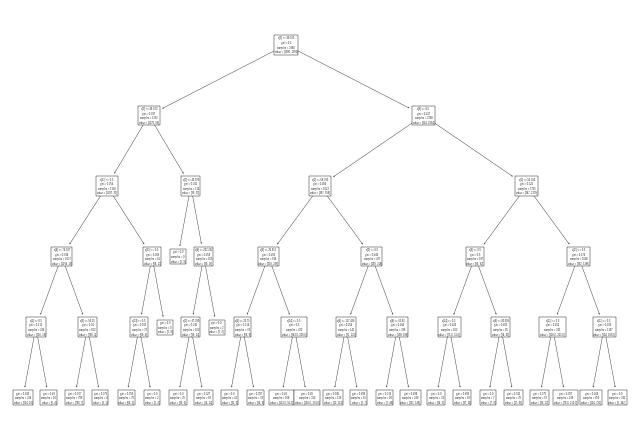

In [51]:
# export decision tree plot
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plot_tree(dt_model)

plt.savefig('decision_tree.svg')

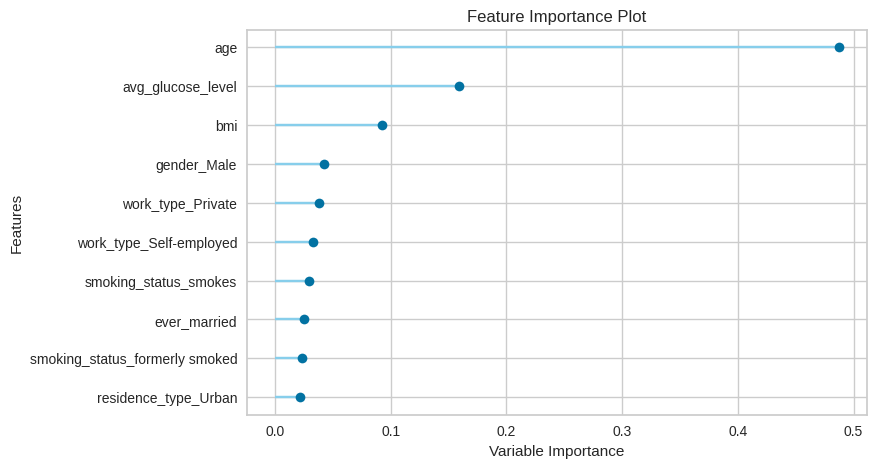

In [16]:
plot_model(dt_model,"feature")

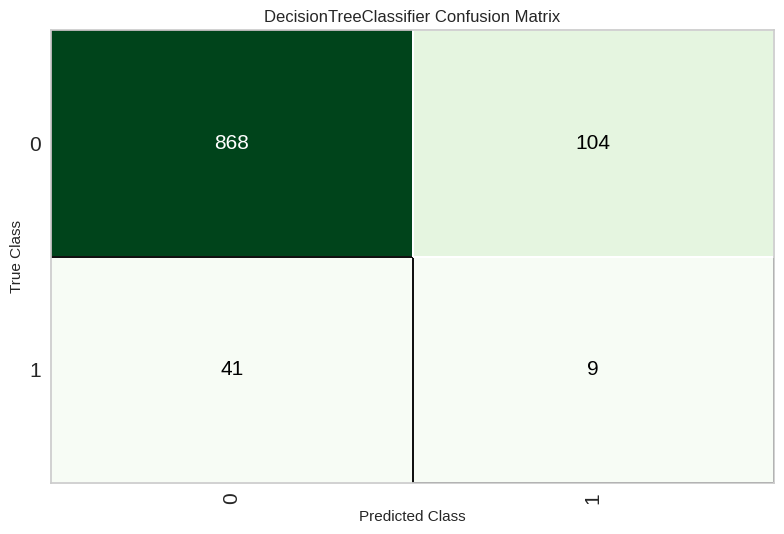

In [17]:
plot_model(dt_model,"confusion_matrix")

In [52]:
# Plot Decision Tree
plot_model(dt_model, plot="parameter")
dt_model

,Parameters
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,5
max_features,None
max_leaf_nodes,None
min_impurity_decrease,0.0
min_samples_leaf,1
min_samples_split,2
min_weight_fraction_leaf,0.0


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=24, splitter='best')

In [55]:
# Get the evaluation metrics of the test set in the decision tree model
predictions = predict_model(dt_model, data=test_data)
holdout_score = pull() # Pulls test set's evaluation metrics

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.7485,0.7516,0.7200,0.1290,0.2188,0.1482,0.2276


### (ii) Bagging for decision tree model

In [54]:
# create boosting ensemble models with just one line of code.
bagging_dt = ensemble_model(dt_model, method="Bagging")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6884,0.7956,0.5980,0.7301,0.6575,0.3769,0.3832
1,0.8769,0.9498,0.9447,0.8319,0.8847,0.7538,0.7608
2,0.8719,0.9544,0.9648,0.8136,0.8828,0.7437,0.7569
3,0.8442,0.9340,0.9397,0.7890,0.8578,0.6884,0.7013
4,0.8518,0.9322,0.9296,0.8043,0.8625,0.7035,0.7122
5,0.8518,0.9529,0.9397,0.7991,0.8637,0.7035,0.7147
6,0.8568,0.9562,0.9799,0.7863,0.8725,0.7136,0.7362
7,0.8719,0.9545,0.9598,0.8162,0.8822,0.7437,0.7555
8,0.8819,0.9643,0.9648,0.8276,0.8910,0.7638,0.7745


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### (iii) Boosting for decision tree model

In [56]:
boosting = ensemble_model(dt_model, method= 'Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6809,0.8165,0.4523,0.8333,0.5863,0.3618,0.4068
1,0.9497,0.9853,0.9698,0.9324,0.9507,0.8995,0.9002
2,0.9045,0.9659,0.9548,0.8676,0.9091,0.8090,0.8132
3,0.9221,0.9763,0.9749,0.8818,0.9260,0.8442,0.8490
4,0.9095,0.9669,0.9548,0.8756,0.9135,0.8191,0.8225
5,0.9271,0.9810,0.9749,0.8899,0.9305,0.8543,0.8582
6,0.9673,0.9915,0.9849,0.9515,0.9679,0.9347,0.9353
7,0.9246,0.9705,0.9548,0.9005,0.9268,0.8492,0.8508
8,0.9397,0.9787,0.9497,0.9310,0.9403,0.8794,0.8796


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

## (iv) AutoML

In [44]:
# Use these splits in PyCaret
from pycaret.classification import *
automl_experiment = setup(data=train_data_res,
                          target="stroke",
                          test_data=test_data,
                          session_id=24, # seed config to ensure experiment's reproducility
                          preprocess=False, # since we've manually do the feature engineer
                          #max_encoding_ohe = 25, # one hot encoding
                          normalize=True,
                          normalize_method = 'zscore', # apply zscore for numeric feature
                          fix_imbalance=False, # fix imbalance via smote
                          # fix_imbalance_method='SMOTE',
                          experiment_name = "automl_stroke_classification",
                          log_experiment=True, # log your experiment into MlFlow at https://mlflow.tanyongsheng.site
                          log_plots=True,
                          log_profile=True,
                          log_data=True,
                          profile=True,
                          fold=10,
                          index=False)

# get a list of top 3 models
best_model = compare_models(sort="F1")

,Description,Value
0,Session id,24
1,Target,stroke
2,Target type,Binary
3,Original data shape,"(5002, 16)"
4,Transformed data shape,"(5002, 16)"
5,Transformed train set shape,"(3980, 16)"
6,Transformed test set shape,"(1022, 16)"
7,Numeric features,6


Loading profile... Please Wait!


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9276,0.9835,0.9322,0.9217,0.9188,0.8553,0.8629,0.6710
lightgbm,Light Gradient Boosting Machine,0.9296,0.9825,0.9296,0.9279,0.9183,0.8593,0.8681,0.9600
et,Extra Trees Classifier,0.9307,0.9799,0.9291,0.9296,0.9176,0.8613,0.8706,0.8710
xgboost,Extreme Gradient Boosting,0.9259,0.9823,0.9332,0.9188,0.9165,0.8518,0.8608,0.1960
catboost,CatBoost Classifier,0.9244,0.9811,0.9312,0.9190,0.9146,0.8487,0.8585,3.8010
gbc,Gradient Boosting Classifier,0.8960,0.9656,0.9106,0.8811,0.8870,0.7920,0.8003,0.4930
knn,K Neighbors Classifier,0.8759,0.9368,0.9719,0.8157,0.8869,0.7518,0.7662,0.0560
dt,Decision Tree Classifier,0.8854,0.8854,0.8995,0.8721,0.8797,0.7709,0.7771,0.0330
ada,Ada Boost Classifier,0.8585,0.9481,0.8915,0.8330,0.8540,0.7171,0.7263,0.1950
ridge,Ridge Classifier,0.8578,0.9319,0.8638,0.8521,0.8498,0.7156,0.7227,0.0240


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [25]:
# get the pipeline
best_model_pipeline = get_config("pipeline")
best_model_pipeline

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('clean_column_names',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+')))],
         verbose=False)

In [26]:
# hyperparameter tuning
tuned_best_model = tune_model(best_model, fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6734,0.8399,0.4925,0.7717,0.6012,0.3467,0.3719
1,0.9397,0.9789,0.9598,0.9227,0.9409,0.8794,0.8801
2,0.9171,0.9818,0.9698,0.8773,0.9212,0.8342,0.8389
3,0.9121,0.9762,0.9598,0.8761,0.9161,0.8241,0.8279
4,0.9121,0.9701,0.9548,0.8796,0.9157,0.8241,0.8271
5,0.9146,0.9815,0.9698,0.8733,0.9190,0.8291,0.8343
6,0.9271,0.9857,0.9698,0.8935,0.9301,0.8543,0.8574
7,0.9322,0.9768,0.9698,0.9019,0.9346,0.8643,0.8668
8,0.9447,0.9919,0.9849,0.9116,0.9469,0.8894,0.8923


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [27]:
# making prediction
predictions = predict_model(tuned_best_model, data = test_data)
predictions

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8982,0.7655,0.2200,0.1447,0.1746,0.1228,0.1259


,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,gender_Male,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Urban,stroke,prediction_label,prediction_score
0,63.0,0,0,1,78.230003,34.799999,True,False,True,False,False,True,False,False,False,0,0,0.91
1,43.0,0,0,1,86.669998,33.299999,False,False,True,False,False,True,False,False,True,0,0,1.00
2,23.0,0,0,0,126.669998,28.700001,False,False,False,True,False,True,False,False,True,0,0,1.00
3,21.0,0,0,0,208.169998,24.900000,False,False,True,False,False,True,False,False,True,0,0,0.96
4,67.0,0,0,1,113.339996,26.299999,True,True,False,False,False,True,False,False,False,0,1,0.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,82.0,0,0,0,82.209999,26.000000,False,False,True,False,False,False,True,False,True,0,1,0.54
1018,34.0,0,0,0,120.059998,33.000000,False,False,True,False,False,False,False,False,False,0,0,0.98
1019,50.0,0,0,1,92.150002,20.799999,False,False,True,False,False,False,False,False,True,0,0,0.96
1020,15.0,0,0,0,62.570000,32.299999,True,False,True,False,False,False,False,True,False,0,0,0.95


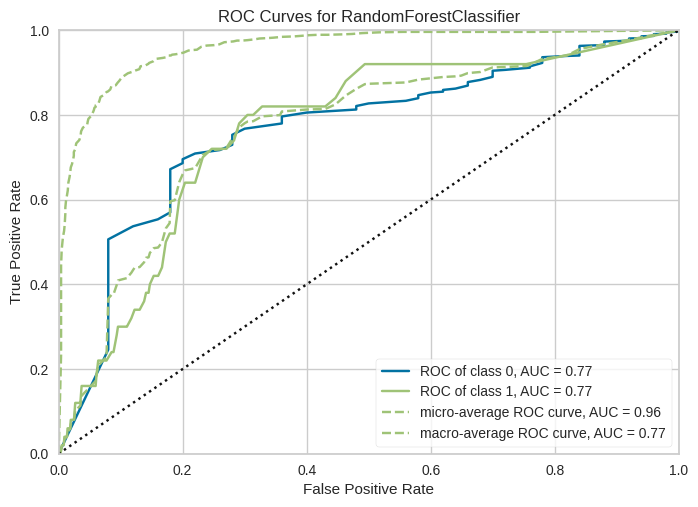

In [28]:
plot_model(tuned_best_model, plot="auc")

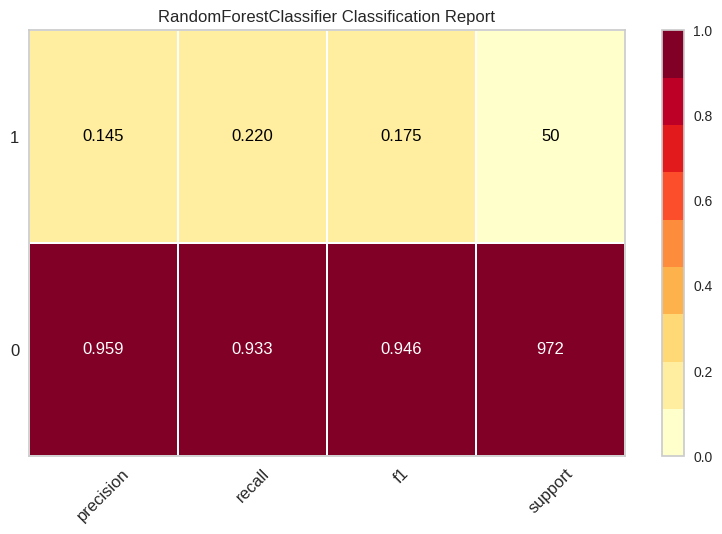

In [29]:
plot_model(tuned_best_model, plot='class_report')

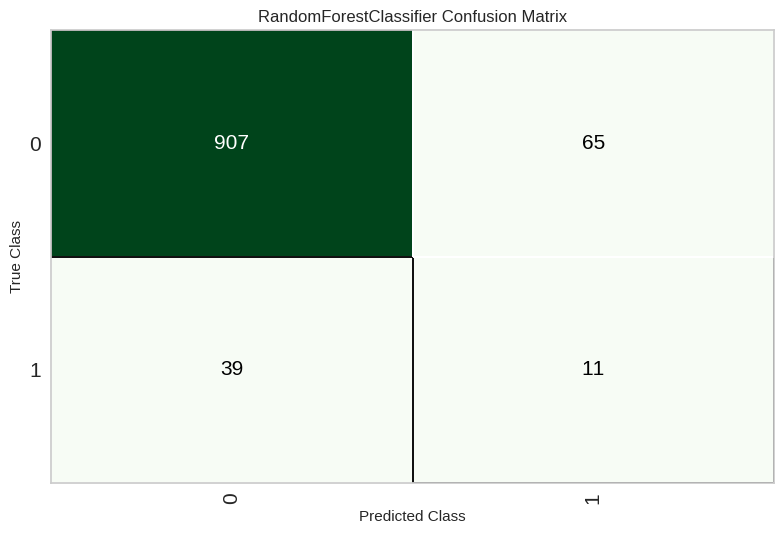

In [30]:
plot_model(tuned_best_model, plot="confusion_matrix")

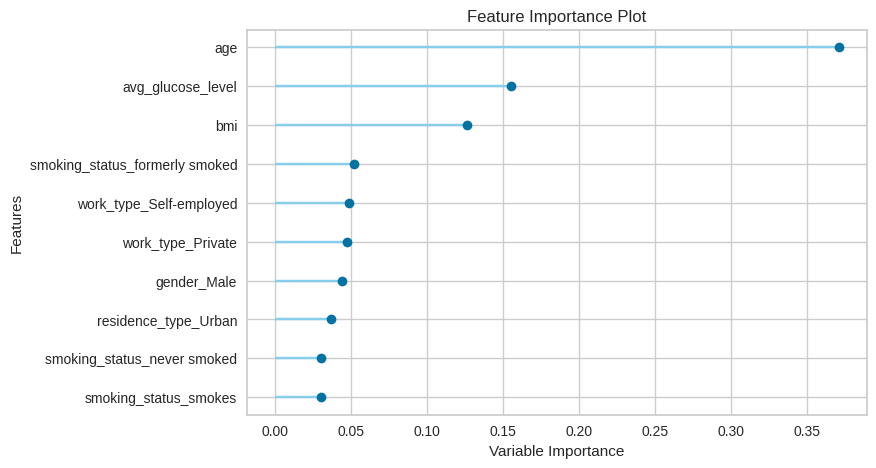

In [31]:
plot_model(tuned_best_model, plot='feature')

In [32]:
evaluate_model(tuned_best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

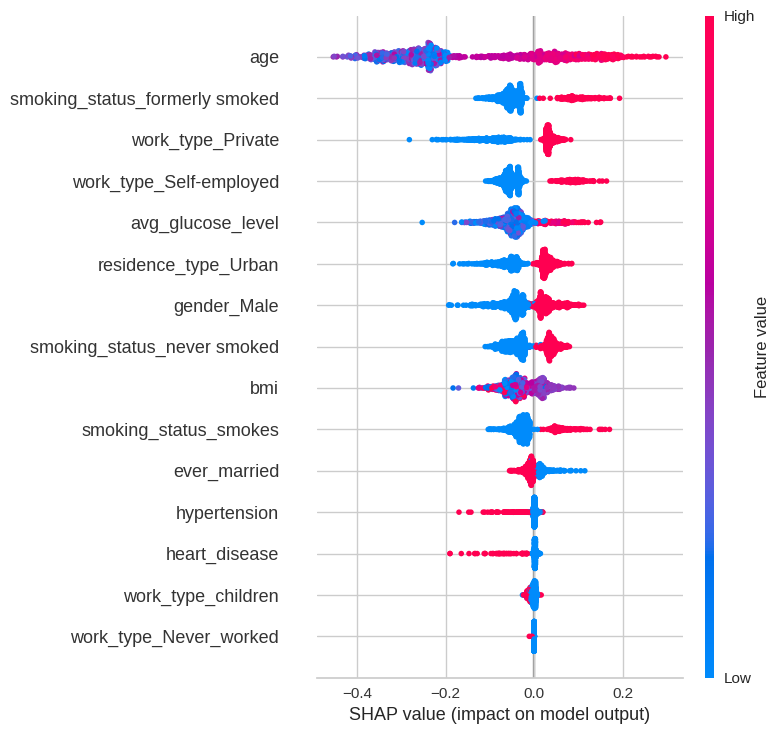

In [33]:
interpret_model(tuned_best_model)

In [34]:
predictions.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'avg_glucose_level', 'bmi', 'gender_Male',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'residence_type_Urban',
       'stroke', 'prediction_label', 'prediction_score'],
      dtype='object')

# Save model

In [35]:
# save model
save_model(tuned_best_model, 'tuned_best_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('clean_column_names',
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                 ('trained_model',
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='sqrt',
                                         max_leaf_nodes=None, max_samples=None,
                                         min_impurity_decrease=0.0,
                                         min_samples_leaf=1, min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         monotonic_cst=None, n_estimators=100,
                                         n_jobs=-1, oob_score=False,
                                        

## Load model

In [36]:
# load model
tuned_best_model = load_model(model_name='tuned_best_model')

Transformation Pipeline and Model Successfully Loaded


In [37]:
tuned_best_model

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('clean_column_names',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                ('trained_model',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        monotonic_cst=None, n_estimators=100,
                                        n_jobs=-1, oob_score=False,
                                        random_state=24, verbose=0,
                                        warm_start=False))],
         verbose=False)

In [41]:
# this will generate a python file: tuned_best_model.py with a pickle model file: tuned_best_model.pkl
create_api(tuned_best_model, 'tuned_best_model')

API successfully created. This function only creates a POST API, it doesn't run it automatically. To run your API, please run this command --> !python tuned_best_model.py


# Part 2: Deploy Model with Streamlit

In [ ]:
%%writefile ./app.py
import streamlit as st
import pandas as pd
from pycaret.classification import load_model, predict_model

age = 51.0
hypertension = 0
heart_disease = 0
ever_married = 1
avg_glucose_level = 95.9800033569336
bmi = 40.099998474121094
gender_Male = False


smoking_status = st.selectbox(["smoking_status", ["formerly smoked", "never smoked", "smoke currently", ]])
smoking_status_formerly_smoked = False
smoking_status_never_smoked = False
smoking_status_smokes = True
work_type_Never_worked = False
work_type_Private = True
work_type_Self_employed = False,
work_type_children = False,
residence_type_Urban= True

model = load_model("tuned_best_model")

st.title('Stroke Prediction App')

# Collect user input
input_1 = st.number_input('Input 1', min_value=0.0, max_value=10.0)
input_2 = st.number_input('Input 2', min_value=0.0, max_value=10.0)
input_3 = st.number_input('Input 3', min_value=0.0, max_value=10.0)
input_4 = st.number_input('Input 4', min_value=0.0, max_value=10.0)

# Predict the output
if st.button('Predict'):
  input_data = pd.DataFrame([[input_1, input_2, input_3, input_4]],
  columns=['input_1', 'input_2', 'input_3', 'input_4'])
  prediction = predict_model(model, data=input_data)
  st.write(f"The predicted output is: {prediction['Label'].iloc[0]}")

# Computing Environment

In [38]:
!pip install -q watermark

In [39]:
%load_ext watermark

%watermark --iversions

# date
%watermark -u -n -t -z

mlflow  : 2.11.4
pycaret : 3.3.2
pandas  : 2.1.4
sklearn : 1.4.2
imblearn: 0.0

Last updated: Fri Jan 17 2025 08:16:27UTC



## References

- Easy MLOps with PyCaret + MLflow https://towardsdatascience.com/easy-mlops-with-pycaret-mlflow-7fbcbf1e38c6
- Mastering PyCaret and Streamlit: A Comprehensive Guide to Building and Deploying Machine Learning Models https://medium.com/@abhisheky127/mastering-pycaret-and-streamlit-a-comprehensive-guide-to-building-and-deploying-machine-learning-71b28a22655e